In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import yaml

In [8]:
i = 0
j = 0
file = np.load('results/Block_simult_config_{}_fold_{}/predictions.npz'.format(i, j))
targets = file['targets']
outputs = file['outputs']

array([0.26894143, 0.5       ], dtype=float32)

In [12]:
targets.shape, outputs.shape

((558653, 2), (558653, 2))

In [11]:
test = np.log((1/targets[:, 1] - 1))
test.shape

(558653,)

In [19]:
num_folds = 4
num_configs = 18

val_losses = []
alphas = np.zeros(num_configs)

for i in range(num_configs):
    config_val_loss = []
    
    for j in range(num_folds):
        if j == 0:
            config = yaml.load(open('results/Block_simult_config_{}_fold_{}/config.yaml'.format(i, j), 'r'))
            alphas[i] = config['training']['alpha']
        
        file = np.load('results/Block_simult_config_{}_fold_{}/predictions.npz'.format(i, j))
        targets = file['targets']  # .reshape([-1, 2])
        targets[:,1] = np.log((1/targets[:, 1] - 1))   # np.log10(targets[:,1])
        outputs = file['outputs']  # .reshape([-1, 2])
        outputs[:,1] = np.log((1/outputs[:, 1] - 1))  
        outputs[:,1] = 1 / (1 + np.exp(-outputs[:,1]))
        
        accuracy = np.mean((outputs[:,1] > 0.5) == targets[:,1])
        mae = np.mean(np.abs(np.log10(targets[:,0]) - np.log10(outputs[:,0])))
        pi0_inds = (targets[:,1] == 0)
        pi0_mae = np.mean(np.abs(np.log10(targets[pi0_inds,0]) - np.log10(outputs[pi0_inds,0])))
        pion_mae = np.mean(np.abs(np.log10(targets[~pi0_inds,0]) - np.log10(outputs[~pi0_inds,0])))
        
        config_val_loss.append([accuracy, mae, pi0_mae, pion_mae])
    
    config_val_loss = np.array(config_val_loss)
    
    val_losses.append([config_val_loss.mean(axis=0), config_val_loss.mean(axis=0) - config_val_loss.min(axis=0), config_val_loss.max(axis=0) - config_val_loss.mean(axis=0)])

val_losses = np.array(val_losses)
val_losses = val_losses[np.argsort(alphas),:,:]

In [20]:
val_losses.shape

(18, 3, 4)

In [21]:
val_losses[:,0].min()

0.02773253805935383

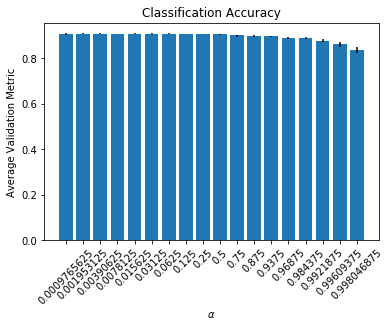

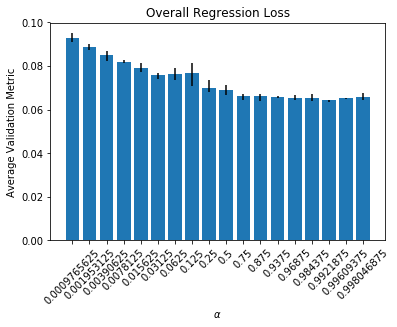

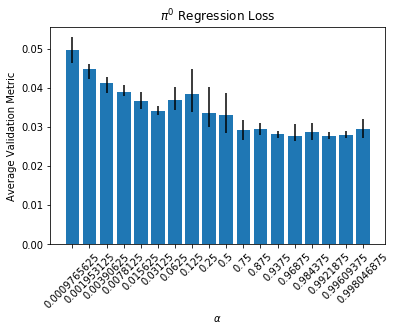

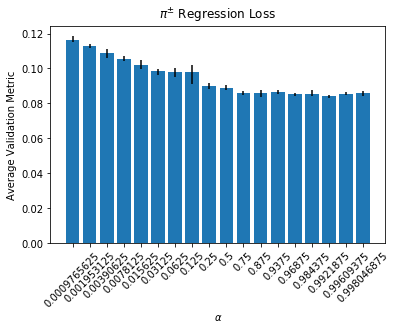

In [22]:
plot_titles = ['Classification Accuracy', 'Overall Regression Loss', '$\\pi^{0}$ Regression Loss',
               '$\\pi^{\\pm}$ Regression Loss']

for i, title in enumerate(plot_titles):
    plt.bar(np.arange(num_configs)+1, val_losses[:,0,i], yerr=val_losses[:,1:,i].T, align='center')
    plt.xticks(ticks=np.arange(num_configs)+1, labels=np.sort(alphas), rotation=45)
    plt.xlabel('$\\alpha$')
    plt.ylabel('Average Validation Metric')
    plt.title(title)
#     plt.savefig('plots/' + title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
max_acc_arg = np.argmax(val_losses[:,0,0])
print(val_losses[max_acc_arg, 0, 0], alphas[max_acc_arg], val_losses[max_acc_arg, 0, 1])
val_losses[:, 0, 2]

0.9080092793963827 0.03125 0.0758187361061573


array([0.04963677, 0.0448984 , 0.04130057, 0.03894203, 0.03662245,
       0.03413556, 0.0368562 , 0.03850492, 0.03359908, 0.03304417,
       0.02929581, 0.0294017 , 0.02816338, 0.02775189, 0.02875084,
       0.02773254, 0.02806491, 0.0295665 ])

In [30]:
best_model = np.where(alphas == 0.5)[0][0]

print(best_model)

predictions = np.load('results/Block_simult_config_{}_fold_0/predictions.npz'.format(best_model))
targets = predictions['targets']
outputs = predictions['outputs']

9


In [31]:
# targets = np.log10(targets.reshape([-1,2])[:,1])
# outputs = 1 / (1 + np.exp(-np.log10(outputs.reshape([-1,2])[:,1])))

targets[:,1] = np.log((1/targets[:, 1] - 1))   # np.log10(targets[:,1])
outputs[:,1] = np.log((1/outputs[:, 1] - 1))  
outputs[:,1] = 1 / (1 + np.exp(-outputs[:,1]))

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc # ConfusionMatrixDisplay, RocCurveDisplay

In [51]:
cm[0,:] =  cm[0,:]/np.sum(cm[0, :])

In [57]:
cm = confusion_matrix(targets[:, 1], outputs[:, 1:] > 0.5) # , normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['$\\pi^{0}$', '$\\pi^{\pm}$'])
# disp.plot()
# plt.savefig('plots/cm.png', dpi=300, bbox_inches='tight')
# plt.show()
cm = cm.astype(float)
cm[0,:] =  cm[0,:].astype(float)/np.sum(cm[0, :]).astype(float)
cm[1,:] =  cm[1,:].astype(float)/np.sum(cm[1, :]).astype(float)

cm

array([[0.88066719, 0.11933281],
       [0.0808221 , 0.9191779 ]])

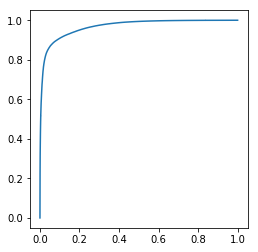

AUC = 0.97


In [62]:
fpr, tpr, _ = roc_curve(targets[:, 1], outputs[:, 1:])
roc_auc = auc(fpr, tpr)
# disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
# disp.plot()
# plt.savefig('plots/roc_auc.png', dpi=300, bbox_inches='tight')
plt.plot(fpr, tpr)
plt.axis('square')
plt.show()
print('AUC = {:.2f}'.format(roc_auc))

In [63]:
class_targets = targets[:, 1:]
class_outputs = outputs[:, 1:]

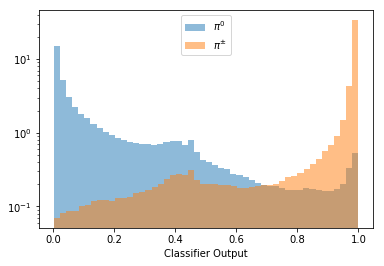

In [64]:
plt.hist(class_outputs[class_targets == 0], 50, density=True, alpha=0.5, label='$\\pi^{0}$')
plt.hist(class_outputs[class_targets == 1], 50, density=True, alpha=0.5, label='$\\pi^{\\pm}$')
plt.legend()
plt.xlabel('Classifier Output')
plt.yscale('log')
# plt.savefig('plots/class_dist.png', dpi=300, bbox_inches='tight')
plt.show()

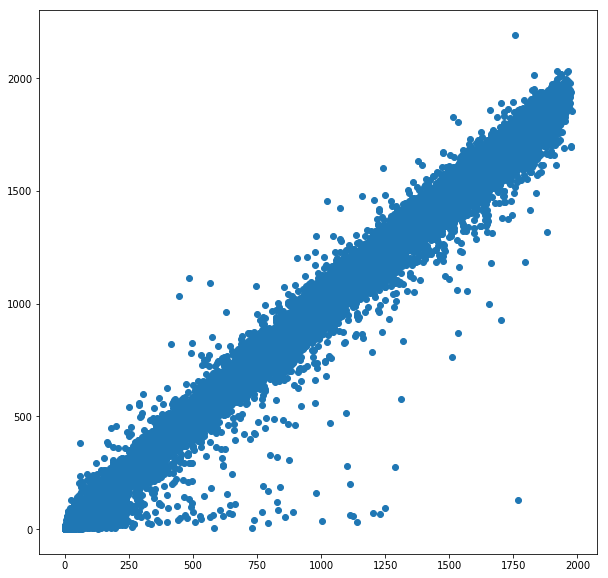

In [67]:
plt.figure(figsize=(10,10))
plt.plot(targets[:, 0], outputs[:, 0], 'o')
plt.show()

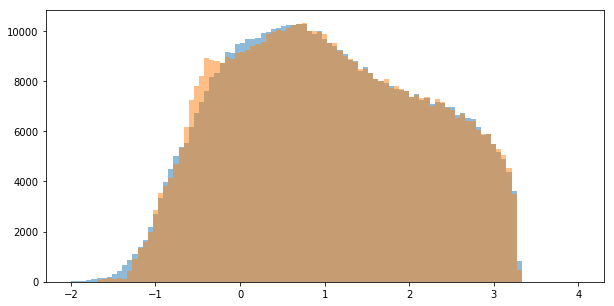

In [73]:
plt.figure(figsize=(10,5))
plt.hist(np.log10(targets[:, 0]), bins=np.linspace(-2,4,100), alpha=.5)
plt.hist(np.log10(outputs[:, 0]), bins=np.linspace(-2,4,100), alpha=.5)
plt.show()